# Specific leaf area and leaf endopolyploidy

James Seery (jseery@mail.uoguelph.ca)

## Setup

Load packages for phylogenetic regression (caper) and function scripts.

In [1]:
rm(list=ls()) # Clear existing memory

tryCatch(    # To run caper, load this package dependency.
    library(mvtnorm),
    error = install.packages("mvtnorm", repos = "http://cran.utstat.utoronto.ca/"))
tryCatch(    # ... and this one too.
    library(ape),
    error = install.packages("ape", repos = "http://cran.utstat.utoronto.ca/"))
tryCatch(    # Now load caper package.
    library(caper),
    error = install.packages("caper", repos = "http://cran.utstat.utoronto.ca/"))
setwd(getwd())
source("pgls_functions.R")

Installing package into 'C:/Users/CCCP/Documents/R/win-library/3.2'
(as 'lib' is unspecified)


package 'mvtnorm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CCCP\AppData\Local\Temp\RtmpGoVynQ\downloaded_packages


Installing package into 'C:/Users/CCCP/Documents/R/win-library/3.2'
(as 'lib' is unspecified)


package 'ape' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CCCP\AppData\Local\Temp\RtmpGoVynQ\downloaded_packages


Installing package into 'C:/Users/CCCP/Documents/R/win-library/3.2'
(as 'lib' is unspecified)


package 'caper' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CCCP\AppData\Local\Temp\RtmpGoVynQ\downloaded_packages


Loading required package: MASS


Load phylogenies: (1) The Angiosperm Phylogeny Group has family-level resolution; therefore, each family is a polytomy. (2) The Zanne phylogeny has species-level resolution, but does not have all species.

In [2]:
setwd("../../Raw_data")

apg.tree = read.tree("APG_phylo/Webb_ages_pruned_unrooted.nwk")
apg.tree = makeLabel(apg.tree) # Fix duplicate node names (because some are blank) error for comparative.data()
z.tree = read.tree("Zanne_phylo/Zanne_pruned.nwk")
z.tree = makeLabel(z.tree)
z.tree$tip.label = tolower(z.tree$tip.label)

Load and compile relevant datasets: specific leaf area (SLA); (2) relative leaf water content (RWC); (3) leaf chlorophyll content (CC); (4) flow cytometry data on genome size and leaf endopolyploidy; and (5) growth form (GF). Endopolyploidy is represented in two ways: (1) leaf endoreduplication index (EI) and (2) mean leaf ploidy (MeanC). EXPORT THIS INTO FUNCTIONS HELD IN Raw_data

In [3]:
SLA_RWC = read.csv("SLA_RWC.csv")
CC = read.csv("CC.csv")
Flow_cytometry = read.csv("Flow_cytometry.csv")
GF = read.csv("GF.csv")
names(GF) = c("Species", "Lifespan", "Ann_per", "GH", "Wood_herb")

# Turn raw data into something sensible
SLA_RWC$SLA = SLA_RWC$LeafArea/(10000*SLA_RWC$DriedMass) # Standardize SLA to square metres per gram
SLA_RWC$RWC = (SLA_RWC$FreshMass - SLA_RWC$DriedMass)/SLA_RWC$DriedMass
Flow_cytometry$EI = rowMeans(cbind(Flow_cytometry$EI.FL2, Flow_cytometry$EI.FL3), na.rm=TRUE) # Get mean EI across the cytometers two detectors: FL2 and FL3
Flow_cytometry$MeanC = rowMeans(cbind(Flow_cytometry$MeanC.FL2, Flow_cytometry$MeanC.FL3), na.rm=TRUE)
GF$A_HP_WP = character(length(GF$Species))
GF$A_HP_WP[GF$Wood_herb == 'H'] = "HP"
GF$A_HP_WP[GF$Ann_per == 'A'] = "A" # This command must come after the former. The former command incorrectly assigns "HP" to annual species.
GF$A_HP_WP[GF$Wood_herb == 'W'] = "WP"

# Get species-level mean of each trait
mean.SLA_RWC = aggregate(data.frame(SLA = SLA_RWC$SLA, RWC = SLA_RWC$RWC),
                         by=list(Species = SLA_RWC$Species), mean, na.rm=TRUE)
mean.CC = aggregate(list(CC = CC$CC),
                    by=list(Species = CC$Species), mean, na.rm=TRUE)
mean.Flow_cytometry = aggregate(data.frame(Genome.size = Flow_cytometry$Genome.size,
                                           EI = Flow_cytometry$EI,
                                           MeanC = Flow_cytometry$MeanC,
                                           Day = Flow_cytometry$Day),
                     by=list(Species = Flow_cytometry$Species), mean, na.rm=TRUE)

# Merge into one data frame
data_partA = merge(mean.SLA_RWC,
                   list(Species = GF$Species, Wood_herb = GF$Wood_herb, A_HP_WP = GF$A_HP_WP),
                   by="Species", all.x=TRUE)
data_partB = merge(mean.Flow_cytometry,
                   mean.CC,
                   by="Species", all=TRUE)
data = merge(data_partA,
             data_partB,
             by="Species", all.x=TRUE)

# Make EI log transformable
data$lnEI = log(data$EI + min(data$EI[data$EI > 0]))

# Make species names lowercase so they match the phylogenies
data$Species = tolower(data$Species)

write.csv(data, file="SLA+endopolyploidy.csv")

Subset data for (1) only herbaceous species and (2) only endopolyploid species.

In [4]:
data.herb = subset(data, data$Wood_herb == 'H')
data.herb$A_HP_WP = droplevels(data.herb$A_HP_WP)
data.endo = subset(data, data$EI >= 0.1)
data.endo$A_HP_WP = droplevels(data.endo$A_HP_WP)

Combine the data and phylogenies into a object of type comparative.data.

In [5]:
z.data = comparative.data(phy=z.tree, data=data, names.col="Species", vcv=TRUE) # vcv=TRUE will do some pre-processing for the regression by calculating the variance-covariance matrix
z.data.herb = comparative.data(phy=z.tree, data=data.herb, names.col="Species", vcv=TRUE)
z.data.endo = comparative.data(phy=z.tree, data=data.endo, names.col="Species", vcv=TRUE)
apg.data = comparative.data(phy=apg.tree, data=data, names.col="Species", vcv=TRUE)
apg.data.herb = comparative.data(phy=apg.tree, data=data.herb, names.col="Species", vcv=TRUE)
apg.data.endo = comparative.data(phy=apg.tree, data=data.endo, names.col="Species", vcv=TRUE)

### Data transformation

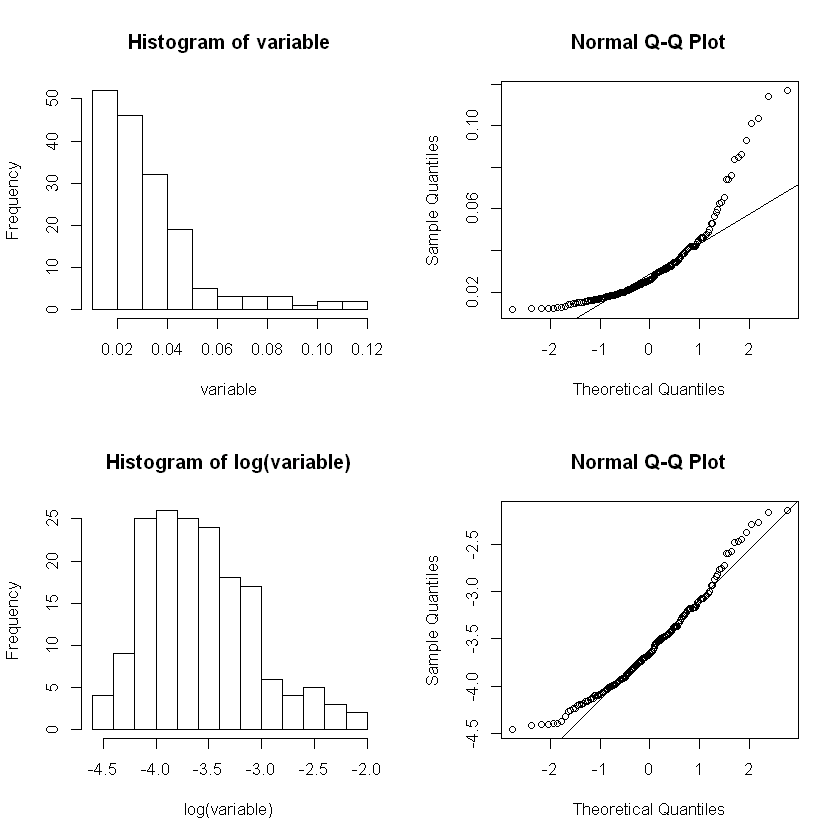

In [6]:
dist.check(data$SLA) # Use log(SLA)

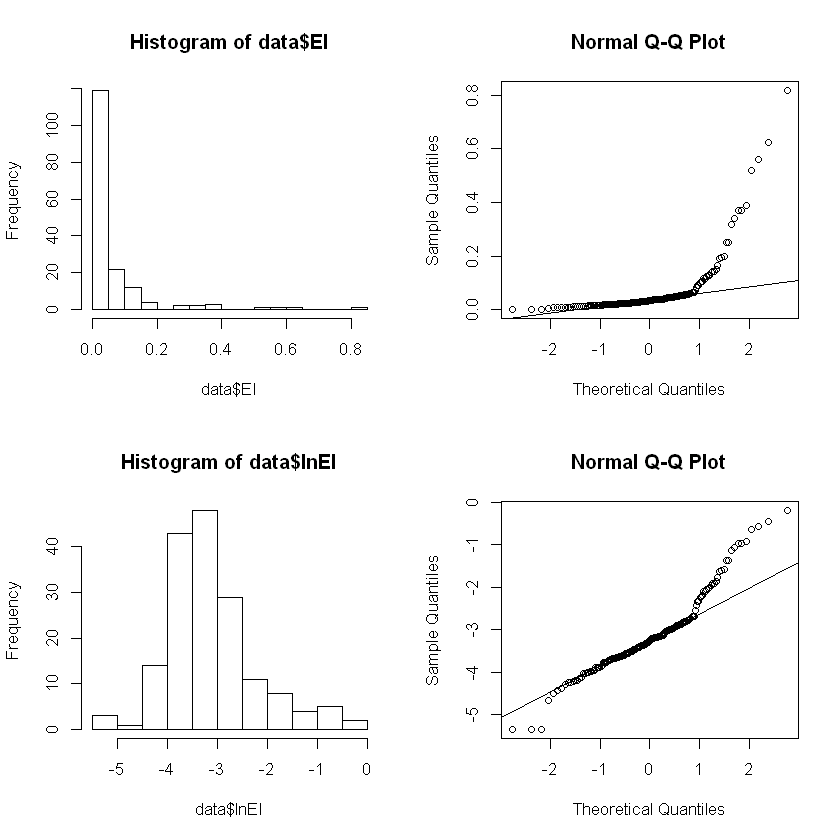

In [7]:
op = par(mfrow = c(2,2))

hist(data$EI, breaks=12)
qqnorm(data$EI)
qqline(data$EI)
hist(data$lnEI, breaks=12)
qqnorm(data$lnEI)
qqline(data$lnEI)

par(op)
# Use lnEI

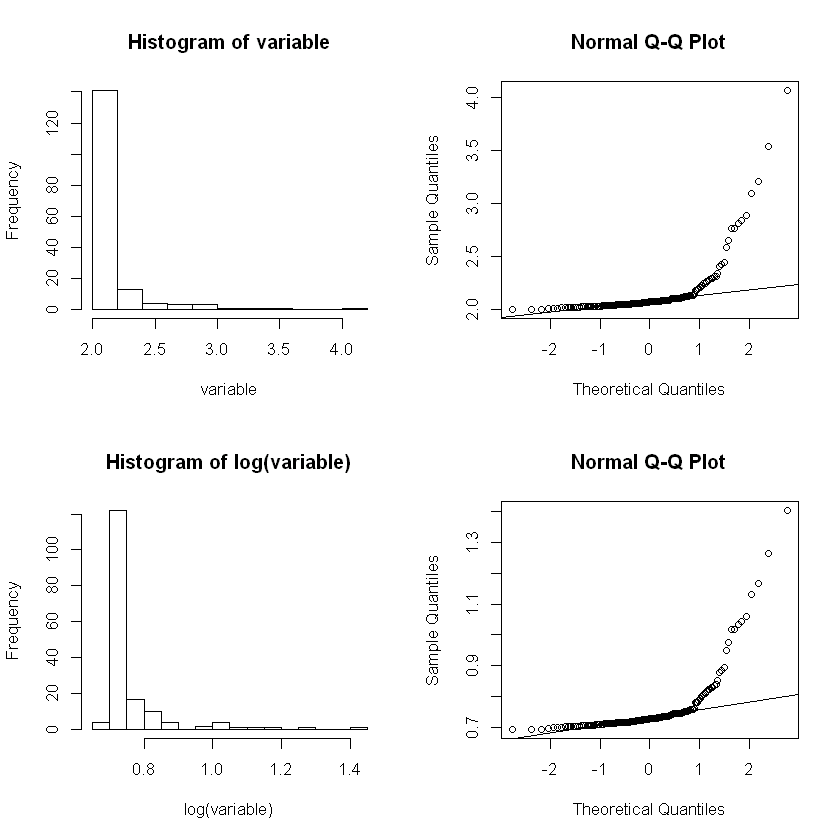

In [8]:
dist.check(data$MeanC) # Don't use MeanC because lnEI is better

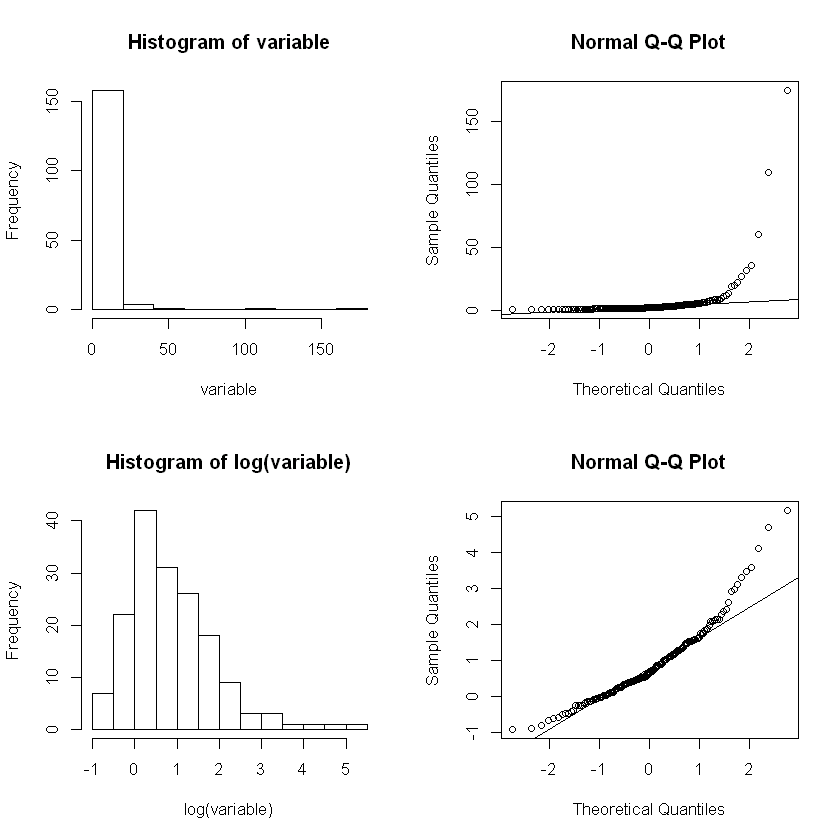

In [9]:
dist.check(data$Genome.size) # Use log(Genome.size)

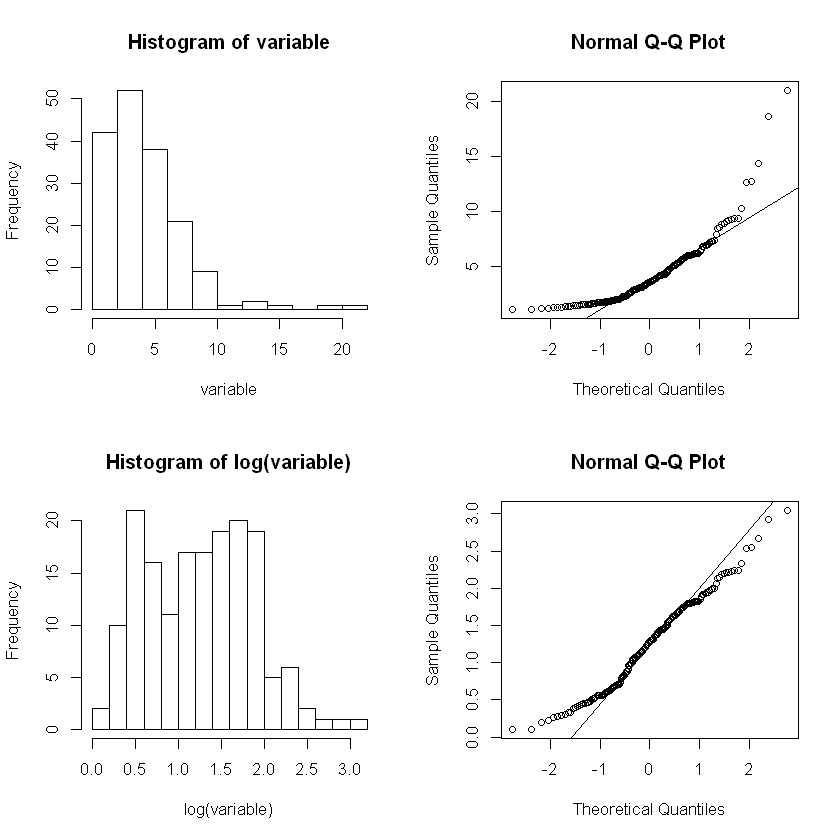

In [10]:
dist.check(data$RWC) # Use log(RWC)

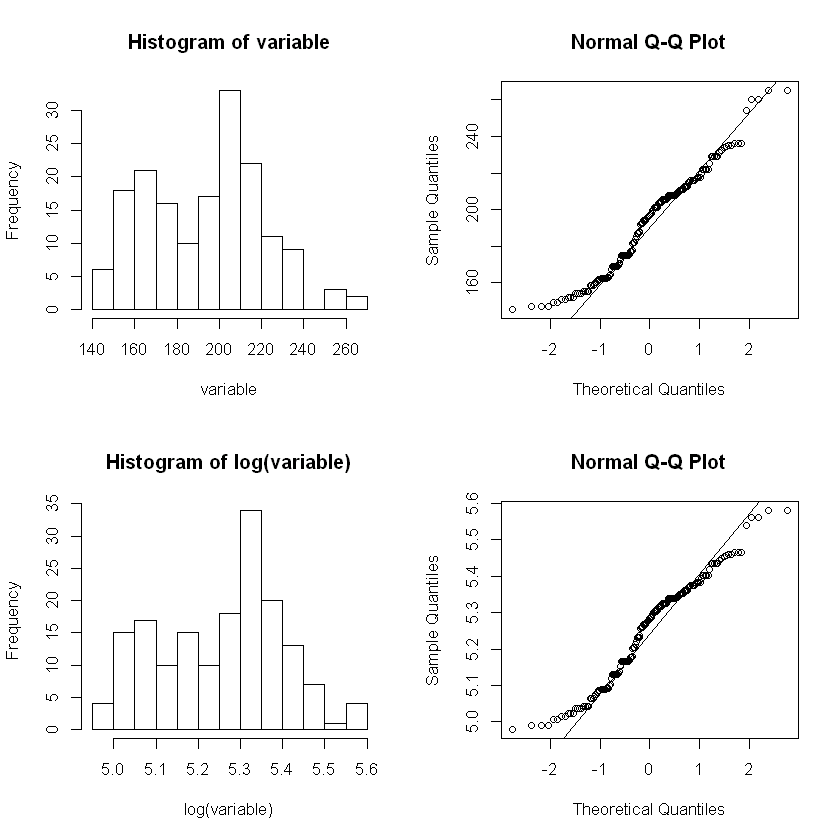

In [11]:
dist.check(data$Day) # Use Day

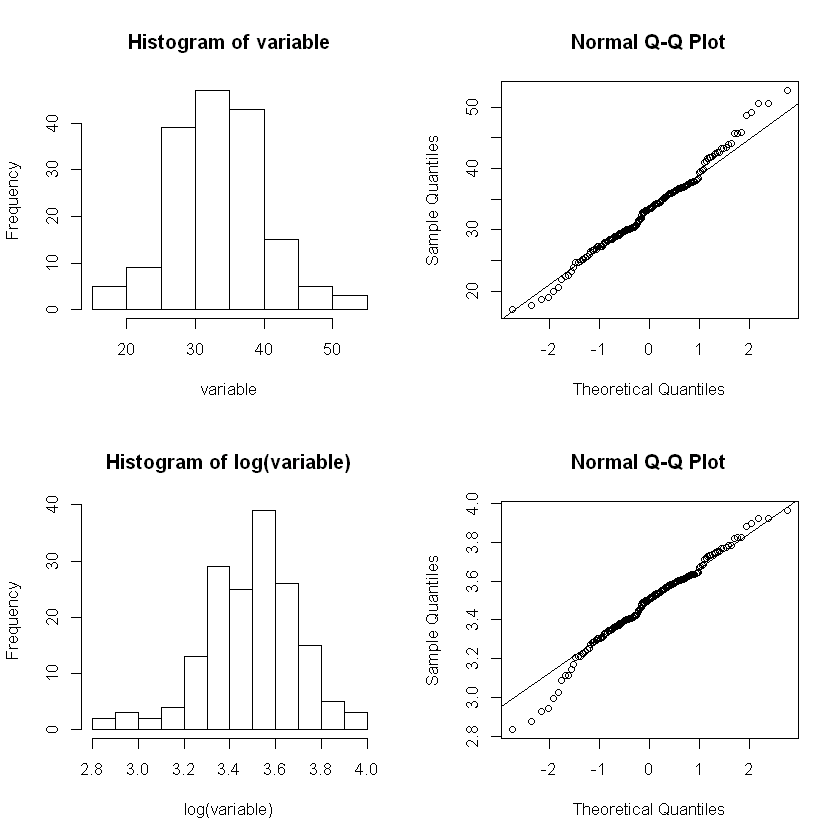

In [12]:
dist.check(data$CC) # Use CC

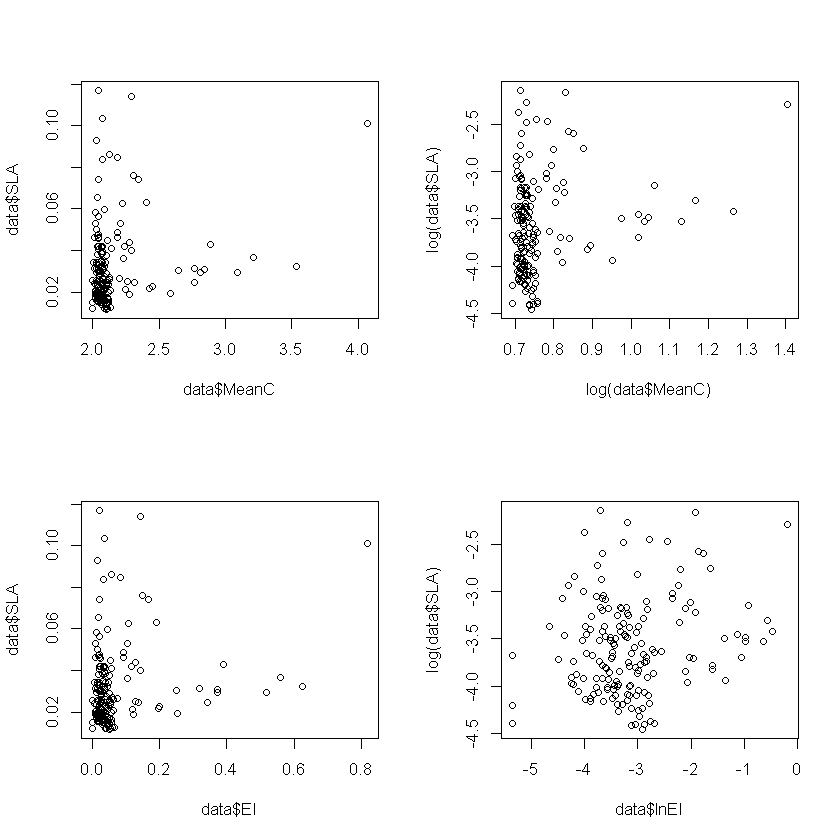

In [13]:
op = par(mfrow = c(2, 2))

plot(data$SLA ~ data$MeanC)
plot(log(data$SLA) ~ log(data$MeanC))
plot(data$SLA ~ data$EI)
plot(log(data$SLA) ~ data$lnEI) # Best

par(op)

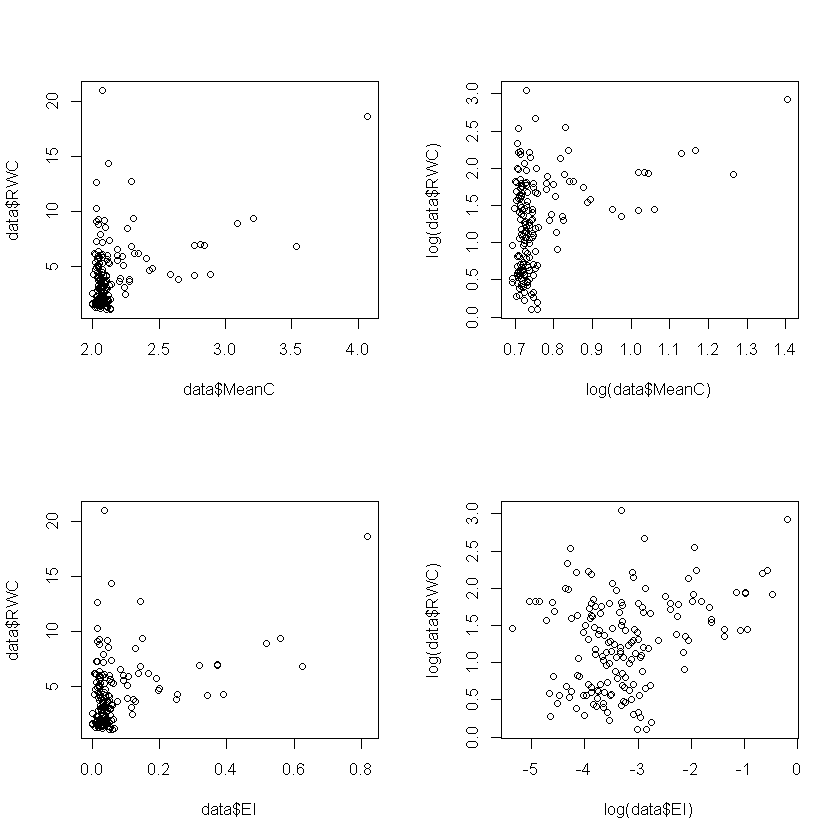

In [14]:
op = par(mfrow = c(2, 2))

plot(data$RWC ~ data$MeanC)
plot(log(data$RWC) ~ log(data$MeanC))
plot(data$RWC ~ data$EI)
plot(log(data$RWC) ~ log(data$EI)) # Best

par(op)

## Regression

#### The relationship between endopolyploidy and growth form. REDO CONFIDENCE INTERVALS


Call:
pgls(formula = lnEI ~ A_HP_WP + log(Genome.size) + Day, data = z.data, 
    lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.147892 -0.029098  0.000435  0.045263  0.154624 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.804
   lower bound : 0.000, p = 1.0133e-09
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (0.641, 0.897)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)      -2.8961984  0.9964435 -2.9065 0.004237 **
A_HP_WPHP        -0.1634087  0.1679454 -0.9730 0.332203   
A_HP_WPWP        -0.7277030  0.2392753 -3.0413 0.002803 **
log(Genome.size) -0.1252301  0.0778970 -1.6076 0.110120   
Day               0.0010834  0.0024270  0.4464 0.655975   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.059 on 143 degrees of freedom
Multiple R-squared: 0.07376,	Adjusted R-squared: 0.04786 
F-statistic: 2.847 on 4 and 

[1] "95% CI for Herbaceous Perennial coefficient"


[1] -0.1358608 -0.1906154

[1] "95% CI for Woody Perennial coefficient"


[1] -0.6884600 -0.7665296


Call:
pgls(formula = lnEI ~ A_HP_WP + log(Genome.size) + Day, data = apg.data, 
    lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.126578 -0.034186 -0.003381  0.028510  0.161939 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.510
   lower bound : 0.000, p = 1.2101e-07
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (0.312, 0.681)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)      -2.4332019  0.5462941 -4.4540 1.587e-05 ***
A_HP_WPHP        -0.1713859  0.1781802 -0.9619  0.337585    
A_HP_WPWP        -0.6568539  0.2269561 -2.8942  0.004339 ** 
log(Genome.size) -0.1317715  0.0736519 -1.7891  0.075512 .  
Day              -0.0011317  0.0024356 -0.4646  0.642839    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04651 on 158 degrees of freedom
Multiple R-squared: 0.06789,	Adjusted R-squared: 0.0443 
F-statistic: 

[1] "95% CI for Herbaceous Perennial coefficient"


[1] -0.1437875 -0.1990891

[1] "95% CI for Woody Perennial coefficient"


[1] -0.6217447 -0.6921831

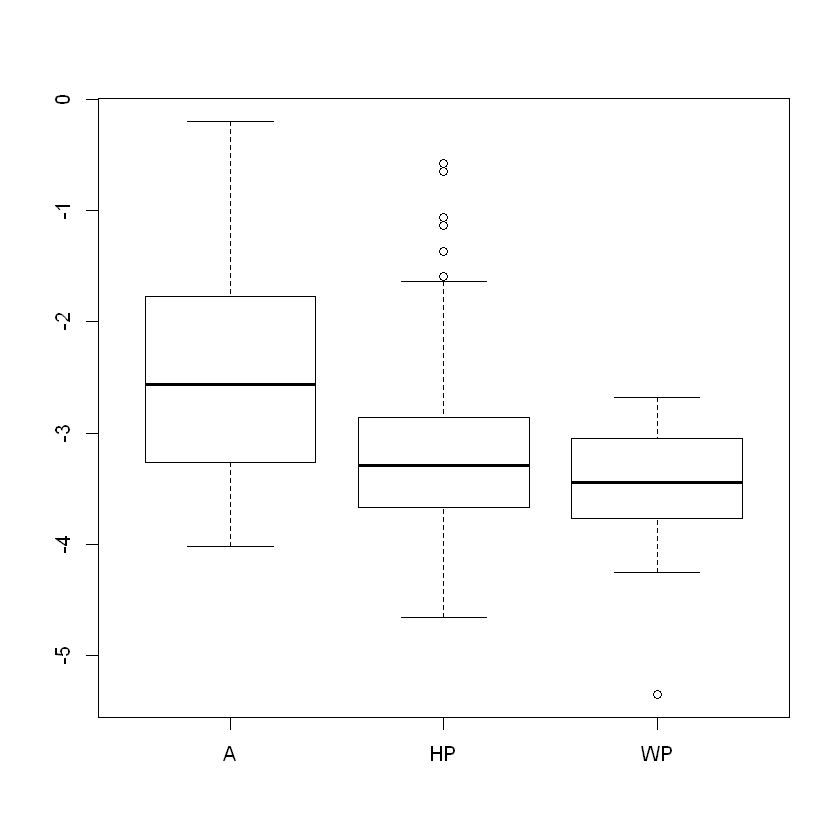

In [15]:
boxplot(lnEI ~ A_HP_WP, data=data)
pglsZ.EI.A_HP_WP = pgls(lnEI ~ A_HP_WP + log(Genome.size) + Day, z.data, lambda='ML')
summary(pglsZ.EI.A_HP_WP)
print("95% CI for Herbaceous Perennial coefficient")
c(-0.1632381 - qt(0.025, 146)*0.1679523/sqrt(147), -0.1632381 + qt(0.025, 146)*0.1679523/sqrt(147))
print("95% CI for Woody Perennial coefficient")
c(-0.7274948 - qt(0.025, 146)*0.2394684/sqrt(147), -0.7274948 + qt(0.025, 146)*0.2394684/sqrt(147))
pglsAPG.EI.A_HP_WP = pgls(lnEI ~ A_HP_WP + log(Genome.size) + Day, apg.data, lambda='ML')
summary(pglsAPG.EI.A_HP_WP) # very similar
print("95% CI for Herbaceous Perennial coefficient")
c(-0.1714383 - qt(0.025, 161)*0.1782131/sqrt(162), -0.1714383 + qt(0.025, 161)*0.1782131/sqrt(162))
print("95% CI for Woody Perennial coefficient")
c(-0.6569639 - qt(0.025, 161)*0.2269929/sqrt(162), -0.6569639 + qt(0.025, 161)*0.2269929/sqrt(162))


Call:
pgls(formula = lnEI ~ Wood_herb + log(Genome.size) + Day, data = z.data, 
    lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.176338 -0.027805  0.009155  0.051135  0.171862 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.809
   lower bound : 0.000, p = 5.2546e-11
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (0.657, 0.898)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)      -3.0296021  0.9959769 -3.0418 0.002795 **
Wood_herbW       -0.6095005  0.2079093 -2.9316 0.003924 **
log(Genome.size) -0.1326006  0.0775976 -1.7088 0.089638 . 
Day               0.0010827  0.0024253  0.4464 0.655980   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05944 on 144 degrees of freedom
Multiple R-squared: 0.06697,	Adjusted R-squared: 0.04753 
F-statistic: 3.445 on 3 and 144 DF,  p-value: 0.01843 

[1] 327.5547


Call:
pgls(formula = lnEI ~ Wood_herb + log(Genome.size) + Day, data = apg.data, 
    lambda = "ML")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.12937 -0.02300  0.00341  0.02929  0.16256 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.527
   lower bound : 0.000, p = 1.4195e-09
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (0.339, 0.692)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)      -2.5644133  0.5339220 -4.8030 3.586e-06 ***
Wood_herbW       -0.5354691  0.1898954 -2.8198  0.005417 ** 
log(Genome.size) -0.1423402  0.0733226 -1.9413  0.053992 .  
Day              -0.0011014  0.0024376 -0.4519  0.651992    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04679 on 159 degrees of freedom
Multiple R-squared: 0.06187,	Adjusted R-squared: 0.04417 
F-statistic: 3.495 on 3 and 159 DF,  p-value: 0.01704 

[1] 366.6861

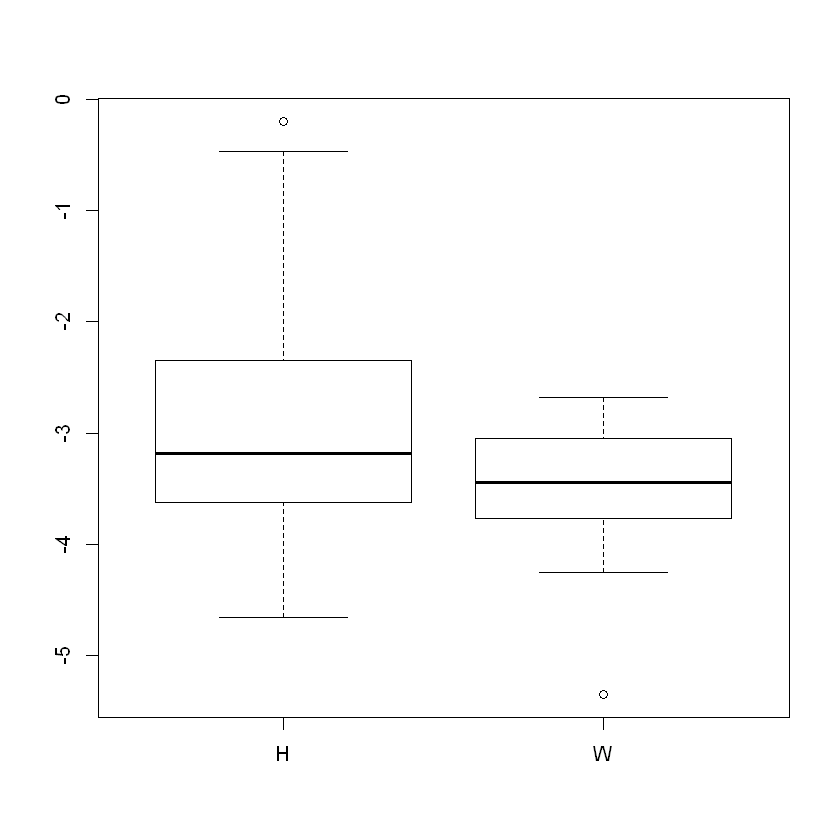

In [16]:
# There is no difference between HP and A; therefore, the only growth form difference is between herbaceous and woody.
# Replace instances of A_HP_WP (three growth form categories) with Wood_herb (two growth form categories)
boxplot(lnEI ~ Wood_herb, data=data)
pglsZ.EI.Wood_herb = pgls(lnEI ~ Wood_herb + log(Genome.size) + Day, z.data, lambda='ML')
summary(pglsZ.EI.Wood_herb)
AIC(pglsZ.EI.Wood_herb) # 327.55 <- Best score
pglsAPG.EI.Wood_herb = pgls(lnEI ~ Wood_herb + log(Genome.size) + Day, apg.data, lambda='ML')
summary(pglsAPG.EI.Wood_herb)
AIC(pglsAPG.EI.Wood_herb) # 366.7467


Call:
pgls(formula = lnEI ~ Wood_herb + log(Genome.size), data = z.data, 
    lambda = 0.527)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.156259 -0.035802 -0.004442  0.022066  0.109600 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.527
delta  [Fix]  : 1.000

Coefficients:
                  Estimate Std. Error t value  Pr(>|t|)    
(Intercept)      -2.765572   0.569361 -4.8573 3.049e-06 ***
Wood_herbW       -0.660577   0.174471 -3.7862 0.0002234 ***
log(Genome.size) -0.139343   0.074191 -1.8782 0.0623675 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04572 on 145 degrees of freedom
Multiple R-squared: 0.09768,	Adjusted R-squared: 0.08523 
F-statistic: 7.848 on 2 and 145 DF,  p-value: 0.0005804 

[1] 335.505

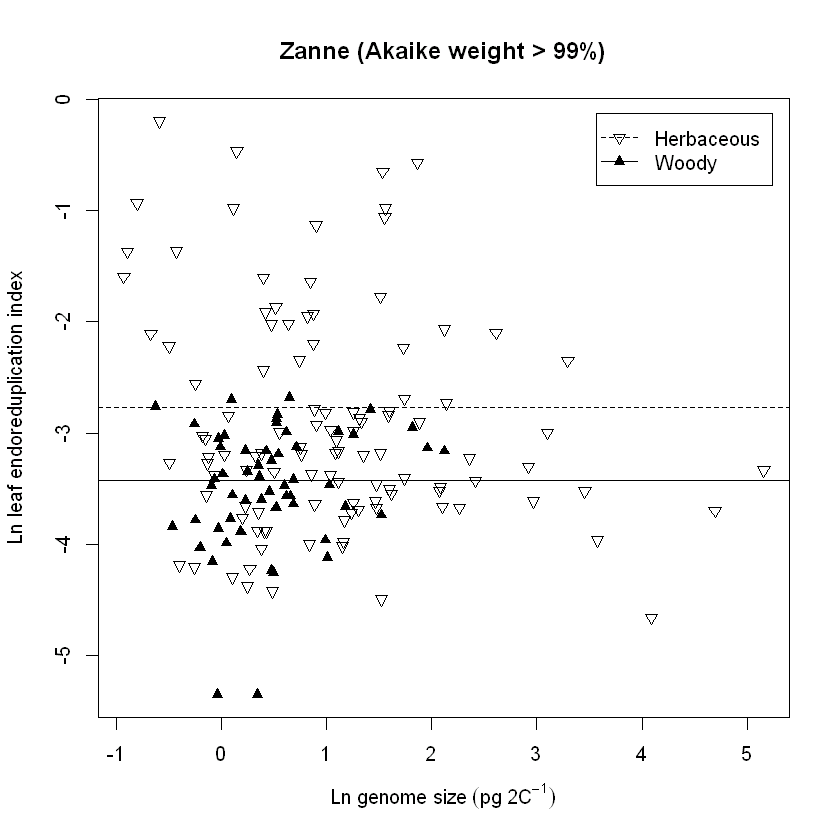

In [17]:
# For plotting, remove Day.
pglsZ.EI.Wood_herb.simple = pgls(lnEI ~ Wood_herb + log(Genome.size), z.data, lambda=0.527)
summary(pglsZ.EI.Wood_herb.simple)
AIC(pglsZ.EI.Wood_herb.simple)
#windows(width=10, height=10)
plot(lnEI ~ log(Genome.size), type='n', data, ylab="Ln leaf endoreduplication index", xlab=expression("Ln genome size" ~ (pg ~ "2C"^{-1})), main="Zanne (Akaike weight > 99%)")
points(lnEI ~ log(Genome.size), data=data[data$Wood_herb == "H", ], pch=6)
points(lnEI ~ log(Genome.size), data=data[data$Wood_herb == "W", ], pch=17)
abline(pglsZ.EI.Wood_herb.simple$model$coef[1], 0, lty=2)
# text(x=4.4, -4, labels="p = ???")
# text(x=4.52, -4.35, labels="AIC = ???")
abline(pglsZ.EI.Wood_herb.simple$model$coef[1] + pglsZ.EI.Wood_herb.simple$model$coef[2], 0)
# text(x=4.4, -2.4, labels="p = ???")
# text(x=4.52, -2.75, labels="AIC = ???")
legend("topright",
       inset = 0.025, 
       c("Herbaceous", "Woody"),
       lty = c(2,1),
       pch = c(6,17))

#### The relationship between SLA and endopolyploidy via RWC

Regression. There is no interaction effect of endopolyploidy and growth form on either SLA or RWC.

##### SLA and endopolyploidy for Angiosperms in general

Lack of correlation between endopolyploidy and the response variables

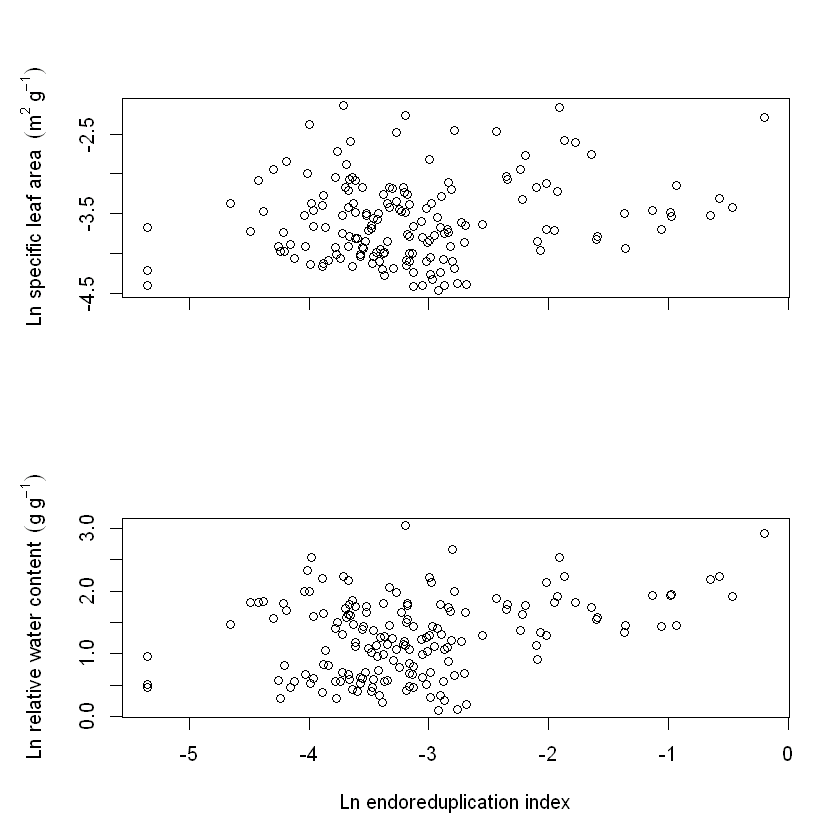

In [18]:
EI.plots(data)

Significant relationships with SLA

In [19]:
pglsAPG.SLA.EI = pgls(log(SLA) ~ lnEI + Wood_herb + CC + log(Genome.size) + Day, apg.data, lambda = 'ML')
summary(pglsAPG.SLA.EI) # EI n.s.
AIC(pglsAPG.SLA.EI) # 114.5968 !!!!!
pglsZ.SLA.EI = pgls(log(SLA) ~ lnEI + Wood_herb + CC + log(Genome.size) + Day, z.data, lambda = 'ML')
summary(pglsZ.SLA.EI) # EI n.s.
AIC(pglsZ.SLA.EI) # 115.7


Call:
pgls(formula = log(SLA) ~ lnEI + Wood_herb + CC + log(Genome.size) + 
    Day, data = apg.data, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.053029 -0.013032 -0.000106  0.011769  0.058029 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.430
   lower bound : 0.000, p = 0.004703
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (0.113, 0.688)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)      -1.6174013  0.2883016 -5.6101 8.918e-08 ***
lnEI             -0.0452969  0.0362703 -1.2489  0.213572    
Wood_herbW       -0.6778635  0.0848127 -7.9925 2.680e-13 ***
CC               -0.0352625  0.0039917 -8.8341 1.776e-15 ***
log(Genome.size) -0.0681221  0.0334010 -2.0395  0.043075 *  
Day              -0.0029681  0.0011110 -2.6716  0.008344 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02077 on 157 degrees of f

[1] 114.597


Call:
pgls(formula = log(SLA) ~ lnEI + Wood_herb + CC + log(Genome.size) + 
    Day, data = z.data, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.056706 -0.011945  0.002442  0.013139  0.061080 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.524
   lower bound : 0.000, p = 0.037063
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (0.101, 0.785)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)      -1.6960868  0.3964056 -4.2787 3.437e-05 ***
lnEI             -0.0489693  0.0391351 -1.2513   0.21289    
Wood_herbW       -0.6597531  0.0864727 -7.6296 3.112e-12 ***
CC               -0.0329259  0.0044047 -7.4752 7.252e-12 ***
log(Genome.size) -0.0720020  0.0355996 -2.0226   0.04500 *  
Day              -0.0029531  0.0011571 -2.5521   0.01176 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0215 on 142 degrees of free

[1] 115.7175


Call:
pgls(formula = log(SLA) ~ Wood_herb + log(Genome.size), data = apg.data, 
    lambda = 0.43)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.094446 -0.015856  0.000108  0.014996  0.059827 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.430
delta  [Fix]  : 1.000

Coefficients:
                  Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)      -3.313207   0.131880 -25.1228 < 2.2e-16 ***
Wood_herbW       -0.704691   0.101984  -6.9098 1.089e-10 ***
log(Genome.size) -0.025094   0.040645  -0.6174    0.5379    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02575 on 160 degrees of freedom
Multiple R-squared: 0.2312,	Adjusted R-squared: 0.2216 
F-statistic: 24.06 on 2 and 160 DF,  p-value: 7.295e-10 


Call:
pgls(formula = log(SLA) ~ Wood_herb + CC, data = apg.data, lambda = 0.43)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.054816 -0.013729 -0.000127  0.012999  0.060288 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.430
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) -2.1576995  0.1678804 -12.8526 < 2.2e-16 ***
Wood_herbW  -0.6450777  0.0831927  -7.7540 9.779e-13 ***
CC          -0.0350993  0.0040668  -8.6307 5.773e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0213 on 160 degrees of freedom
Multiple R-squared: 0.4742,	Adjusted R-squared: 0.4676 
F-statistic: 72.15 on 2 and 160 DF,  p-value: < 2.2e-16 


Call:
pgls(formula = log(SLA) ~ Wood_herb + Day, data = apg.data, lambda = 0.43)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.093494 -0.015203 -0.001021  0.013778  0.063063 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.430
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -2.7403350  0.2787900 -9.8294 < 2.2e-16 ***
Wood_herbW  -0.6725654  0.0990995 -6.7868 2.117e-10 ***
Day         -0.0032404  0.0013475 -2.4047   0.01733 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02533 on 160 degrees of freedom
Multiple R-squared: 0.2563,	Adjusted R-squared: 0.247 
F-statistic: 27.57 on 2 and 160 DF,  p-value: 5.155e-11 

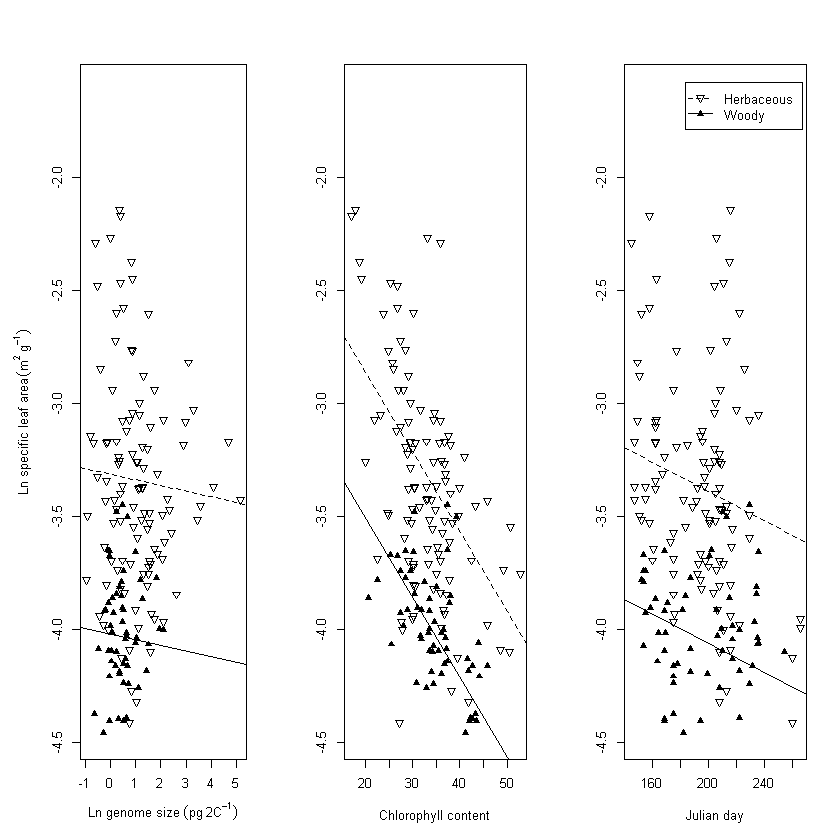

In [20]:
# Close in AIC. Use the APG tree because it has more data
    
# Reduced models for plotting significant relationships. Use lambda from full model.
pglsAPG.SLA.GS = pgls(log(SLA) ~ Wood_herb + log(Genome.size), apg.data, lambda = 0.430)
pglsAPG.SLA.CC = pgls(log(SLA) ~ Wood_herb + CC, apg.data, lambda = 0.430)
pglsAPG.SLA.Day = pgls(log(SLA) ~ Wood_herb + Day, apg.data, lambda = 0.430)

#windows(width=7.5, height=6)
mar.default <- c(5,4,4,2) + 0.1
op=par(mar = mar.default + c(0, 1, 0, 0), mfrow=c(1,3))
plot(log(SLA) ~ log(Genome.size), type = 'n', data, 
     ylab=expression("Ln specific leaf area" ~ (m^{2} ~ g^{-1})), 
     xlab=expression("Ln genome size" ~ (pg ~ "2C"^{-1})), ylim=c(min(log(data$SLA)), -1.618))
points(log(SLA) ~ log(Genome.size), data=data[data$Wood_herb == "W", ], pch=17)
points(log(SLA) ~ log(Genome.size), data=data[data$Wood_herb == "H", ], pch=6)
summary(pglsAPG.SLA.GS)
line.maker(pglsAPG.SLA.GS)

par(mar=mar.default)
plot(log(SLA) ~ CC, type = 'n', data, ylab="", xlab="Chlorophyll content", ylim=c(min(log(data$SLA)), -1.618))
points(log(SLA) ~ CC, data=data[data$Wood_herb == "W", ], pch=17)
points(log(SLA) ~ CC, data=data[data$Wood_herb == "H", ], pch=6)
summary(pglsAPG.SLA.CC)
line.maker(pglsAPG.SLA.CC)

plot(log(SLA) ~ Day, type = 'n', data, ylab="", xlab="Julian day", ylim=c(min(log(data$SLA)), -1.618))
points(log(SLA) ~ Day, data=data[data$Wood_herb == "W", ], pch=17)
points(log(SLA) ~ Day, data=data[data$Wood_herb == "H", ], pch=6)
summary(pglsAPG.SLA.Day)
line.maker(pglsAPG.SLA.Day)

legend("topright",
       inset = 0.025, 
       #cex=0.8,
       c("Herbaceous", "Woody"),
       lty = c(2,1),
       pch = c(6,17))
par(op)

Significant relationships with RWC. Note that the three-category growth form (A_HP_WP) has better fit here.

In [21]:
pglsAPG.RWC.EI = pgls(log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, apg.data, lambda = 'ML')
summary(pglsAPG.RWC.EI)
AIC(pglsAPG.RWC.EI) # 140.8617
print("95% CI for Herbaceous Perennial coefficient")
c(-0.2059660 - qt(0.025, 161)*0.0878047/sqrt(162), -0.2059660 + qt(0.025, 161)*0.0878047/sqrt(162))
print("95% CI for Woody Perennial coefficient")
c(-1.0747413 - qt(0.025, 161)*0.1043139/sqrt(162), -1.0747413 + qt(0.025, 161)*0.1043139/sqrt(162))
# All three GF states are different!
pglsZ.RWC.EI = pgls(log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, z.data, lambda = 'ML')
summary(pglsZ.RWC.EI) # EI is significant (when perenniality is removed) !!!!
AIC(pglsZ.RWC.EI) # 133.7462 !!!!!
print("95% CI for Herbaceous Perennial coefficient")
c(-0.2460751 - qt(0.025, 146)*0.0874583/sqrt(147), -0.2460751 + qt(0.025, 146)*0.0874583/sqrt(147))
print("95% CI for Woody Perennial coefficient")
c(-1.1486675 - qt(0.025, 146)*0.0977786/sqrt(147), -1.1486675 + qt(0.025, 146)*0.0977786/sqrt(147))


Call:
pgls(formula = log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = apg.data, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.058824 -0.014372  0.000343  0.014036  0.045609 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.223
   lower bound : 0.000, p = 0.13126
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (NA, 0.585)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)       2.7392700  0.2980614   9.1903  2.22e-16 ***
lnEI              0.0228770  0.0384723   0.5946  0.552949    
A_HP_WPHP        -0.2059646  0.0878046  -2.3457  0.020249 *  
A_HP_WPWP        -1.0747358  0.1043138 -10.3029 < 2.2e-16 ***
CC               -0.0115820  0.0043527  -2.6609  0.008609 ** 
log(Genome.size)  0.0318423  0.0339972   0.9366  0.350404    
Day              -0.0029263  0.0011645  -2.5129  0.012990 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 

[1] 140.8614

[1] "95% CI for Herbaceous Perennial coefficient"


[1] -0.1923426 -0.2195894

[1] "95% CI for Woody Perennial coefficient"


[1] -1.058556 -1.090926


Call:
pgls(formula = log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = z.data, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.047005 -0.013283 -0.000162  0.011105  0.044334 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.000
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (NA, 0.599)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)       2.5943968  0.2775095   9.3489  2.22e-16 ***
lnEI              0.0385880  0.0379351   1.0172   0.31080    
A_HP_WPHP        -0.2460711  0.0874583  -2.8136   0.00560 ** 
A_HP_WPWP        -1.1486595  0.0977788 -11.7475 < 2.2e-16 ***
CC               -0.0094383  0.0046978  -2.0091   0.04644 *  
log(Genome.size)  0.0310606  0.0327303   0.9490   0.34425    
Day              -0.0020455  0.0011343  -1.8032   0.07349 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 

[1] 133.7458

[1] "95% CI for Herbaceous Perennial coefficient"


[1] -0.2318189 -0.2603313

[1] "95% CI for Woody Perennial coefficient"


[1] -1.132729 -1.164606


Call:
pgls(formula = log(RWC) ~ A_HP_WP + CC, data = z.data, lambda = 1e-06)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.047624 -0.014688  0.000409  0.012155  0.042272 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.000
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)  2.1432497  0.1704001  12.5777 < 2.2e-16 ***
A_HP_WPHP   -0.2630061  0.0836202  -3.1452  0.002016 ** 
A_HP_WPWP   -1.2100610  0.0899766 -13.4486 < 2.2e-16 ***
CC          -0.0097301  0.0047408  -2.0524  0.041941 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01789 on 144 degrees of freedom
Multiple R-squared: 0.6471,	Adjusted R-squared: 0.6397 
F-statistic: 88.01 on 3 and 144 DF,  p-value: < 2.2e-16 

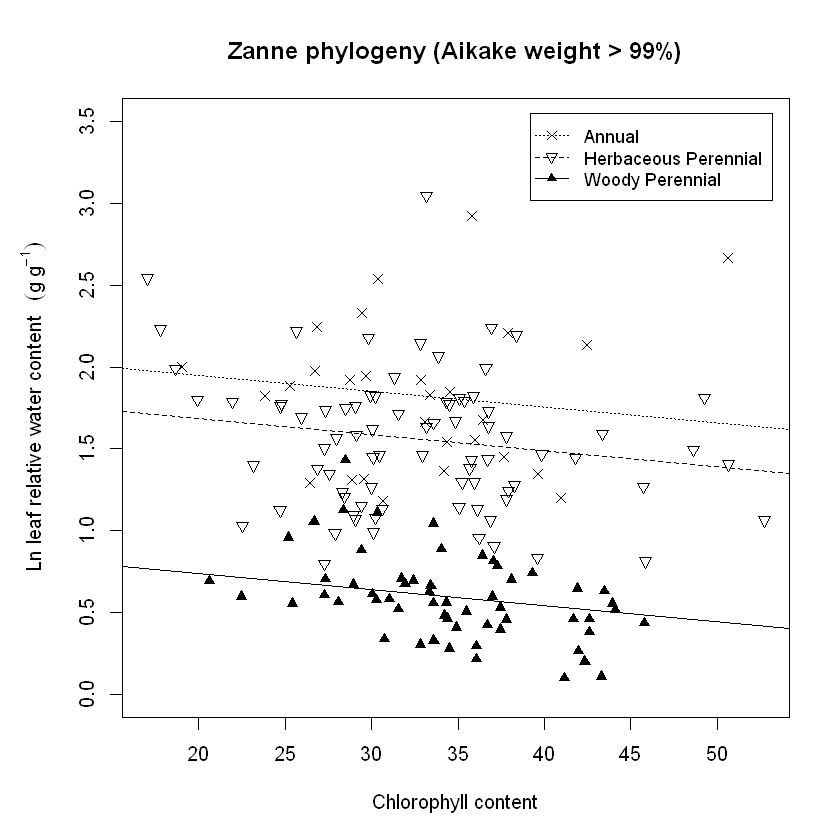

In [22]:
# The Zanne phylogeny has a much better AIC score, so it will be used.

# Reduced model for plotting significant relationships. Lambda from full model.
pglsZ.RWC.CC = pgls(log(RWC) ~ A_HP_WP + CC, z.data, lambda = 1e-06)

op=par(mar = mar.default + c(0, 1, 0, 0))
plot(log(RWC) ~ CC, type='n', data, ylab=expression("Ln leaf relative water content  " ~ (g ~ g^{-1})), 
     xlab="Chlorophyll content", main="Zanne phylogeny (Aikake weight > 99%)", ylim=c(0, 3.5))
points(log(RWC) ~ CC, data=data[data$A_HP_WP == "A", ], pch=4)
points(log(RWC) ~ CC, data=data[data$A_HP_WP == "HP", ], pch=6)
points(log(RWC) ~ CC, data=data[data$A_HP_WP == "WP", ], pch=17)
summary(pglsZ.RWC.CC)
# Annual
abline(pglsZ.RWC.CC$model$coef[1], pglsZ.RWC.CC$model$coef[4], lty=3)
# Herbaceous perennial
abline(pglsZ.RWC.CC$model$coef[1] + pglsZ.RWC.CC$model$coef[2], pglsZ.RWC.CC$model$coef[4], lty=2)
# Woody perennial
abline(pglsZ.RWC.CC$model$coef[1] + pglsZ.RWC.CC$model$coef[3], pglsZ.RWC.CC$model$coef[4], lty=1)
legend("topright",
       inset = 0.025,
       cex=0.9,
       c("Annual", "Herbaceous Perennial", "Woody Perennial"),
       lty = c(3,2,1),
       pch = c(4,6,17))
par(op)

##### SLA and endopolyploidy for herbaceous Angiosperms

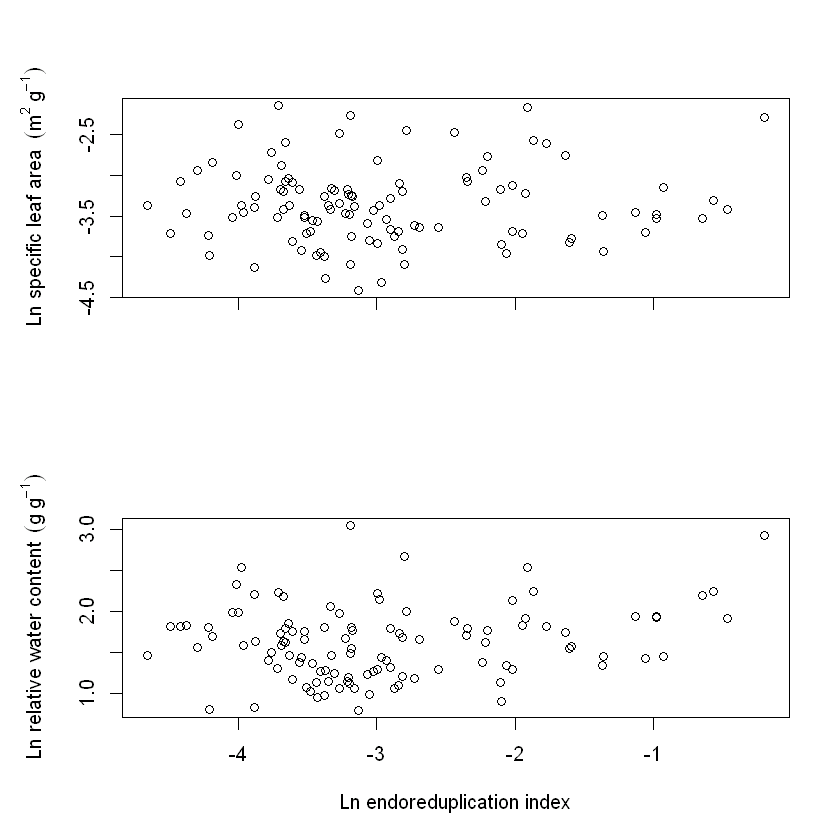

In [23]:
EI.plots(data.herb)

Significant relationships with SLA

In [24]:
pglsAPG.SLA.EI.herb = pgls(log(SLA) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, apg.data.herb, lambda = 'ML')
summary(pglsAPG.SLA.EI.herb) # EI n.s.
AIC(pglsAPG.SLA.EI.herb) # 99.75 !!!!!
pglsZ.SLA.EI.herb = pgls(log(SLA) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, z.data.herb, lambda = 'ML')
summary(pglsZ.SLA.EI.herb) # EI n.s.
AIC(pglsZ.SLA.EI.herb) # 98.93


Call:
pgls(formula = log(SLA) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = apg.data.herb, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.048245 -0.012220  0.001365  0.014570  0.060760 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.278
   lower bound : 0.000, p = 0.11534
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (NA, 0.626)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)      -1.0673893  0.3701382 -2.8838 0.0047939 ** 
lnEI             -0.0577244  0.0452495 -1.2757 0.2049626    
A_HP_WPHP        -0.0596207  0.0901217 -0.6616 0.5097467    
CC               -0.0385106  0.0051360 -7.4982 2.453e-11 ***
log(Genome.size) -0.0846131  0.0386272 -2.1905 0.0307652 *  
Day              -0.0052718  0.0015426 -3.4175 0.0009092 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02191 on 102 degrees of fr

[1] 99.75046


Call:
pgls(formula = log(SLA) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = z.data.herb, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.066014 -0.016964 -0.001941  0.014603  0.061454 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.000
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (NA, 0.715)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)      -0.9525933  0.3457197 -2.7554   0.00704 ** 
lnEI             -0.0448388  0.0442953 -1.0123   0.31401    
A_HP_WPHP        -0.0881643  0.0914310 -0.9643   0.33738    
CC               -0.0344925  0.0056452 -6.1100 2.240e-08 ***
log(Genome.size) -0.0748011  0.0376072 -1.9890   0.04961 *  
Day              -0.0065831  0.0015178 -4.3371 3.627e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02471 on 94 degrees of freedom

[1] 98.92667


Call:
pgls(formula = log(SLA) ~ log(Genome.size), data = apg.data.herb, 
    lambda = 0.278)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.085076 -0.020732 -0.003553  0.018993  0.060054 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.278
delta  [Fix]  : 1.000

Coefficients:
                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)      -3.305882   0.129513 -25.5254   <2e-16 ***
log(Genome.size) -0.036120   0.046947  -0.7694   0.4434    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02798 on 106 degrees of freedom
Multiple R-squared: 0.005554,	Adjusted R-squared: -0.003828 
F-statistic: 0.592 on 1 and 106 DF,  p-value: 0.4434 


Call:
pgls(formula = log(SLA) ~ CC, data = apg.data.herb, lambda = 0.278)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.055097 -0.017436 -0.003051  0.013268  0.059459 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.278
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) -2.0619658  0.2017297 -10.2214 < 2.2e-16 ***
CC          -0.0385708  0.0053716  -7.1805  9.99e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02302 on 106 degrees of freedom
Multiple R-squared: 0.3272,	Adjusted R-squared: 0.3209 
F-statistic: 51.56 on 1 and 106 DF,  p-value: 9.99e-11 


Call:
pgls(formula = log(SLA) ~ Day, data = apg.data.herb, lambda = 0.278)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.083307 -0.019699 -0.001418  0.020280  0.065613 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.278
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -2.4760410  0.3660247 -6.7647 7.576e-10 ***
Day         -0.0046778  0.0018543 -2.5227   0.01313 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02725 on 106 degrees of freedom
Multiple R-squared: 0.05664,	Adjusted R-squared: 0.04774 
F-statistic: 6.364 on 1 and 106 DF,  p-value: 0.01313 

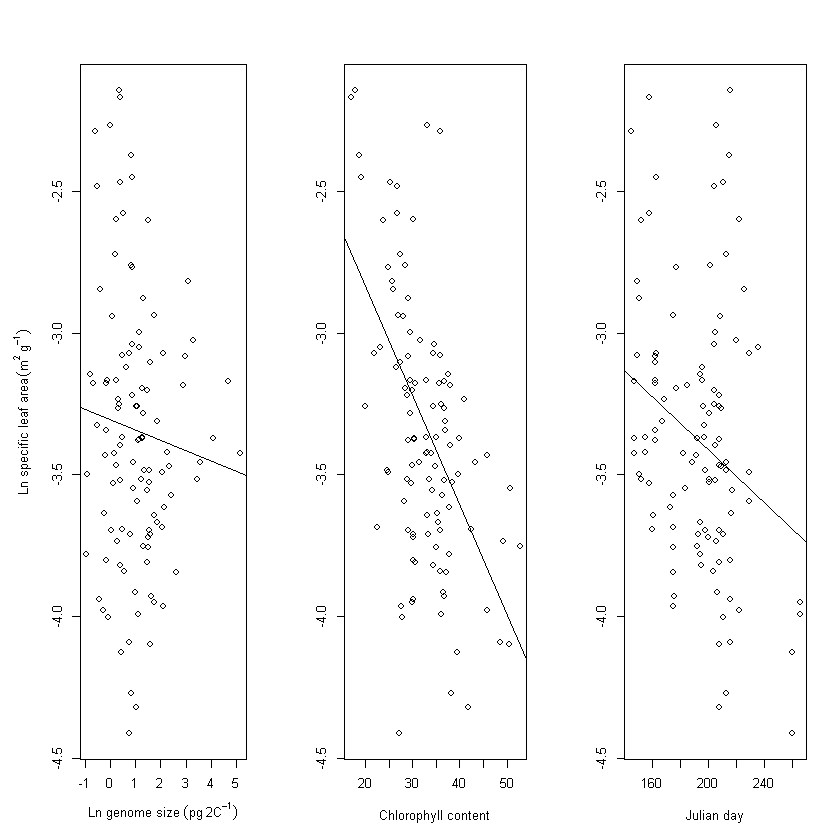

In [25]:
# Zanne and APG are close in AIC. Use the APG tree because it has more data
    
# Reduced models for plotting significant relationships. Use lambda from full model.
pglsAPG.SLA.GS.herb = pgls(log(SLA) ~ log(Genome.size), apg.data.herb, lambda = 0.278)
pglsAPG.SLA.CC.herb = pgls(log(SLA) ~ CC, apg.data.herb, lambda = 0.278)
pglsAPG.SLA.Day.herb = pgls(log(SLA) ~ Day, apg.data.herb, lambda = 0.278)

op=par(mar = mar.default + c(0, 1, 0, 0), mfrow=c(1,3))
plot(log(SLA) ~ log(Genome.size), data.herb, 
     ylab=expression("Ln specific leaf area" ~ (m^{2} ~ g^{-1})), 
     xlab=expression("Ln genome size" ~ (pg ~ "2C"^{-1})))
summary(pglsAPG.SLA.GS.herb)
abline(pglsAPG.SLA.GS.herb$model$coef[1], pglsAPG.SLA.GS.herb$model$coef[2])

par(mar=mar.default)
plot(log(SLA) ~ CC, data.herb, ylab="", xlab="Chlorophyll content")
summary(pglsAPG.SLA.CC.herb)
abline(pglsAPG.SLA.CC.herb$model$coef[1], pglsAPG.SLA.CC.herb$model$coef[2])

plot(log(SLA) ~ Day, data.herb, ylab="", xlab="Julian day")
summary(pglsAPG.SLA.Day.herb)
abline(pglsAPG.SLA.Day.herb$model$coef[1], pglsAPG.SLA.Day.herb$model$coef[2])

par(op)

Significant relationships with RWC.

In [26]:
pglsAPG.RWC.EI.herb = pgls(log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, apg.data.herb, lambda = 'ML')
summary(pglsAPG.RWC.EI.herb)
AIC(pglsAPG.RWC.EI.herb) # 140.8617
pglsZ.RWC.EI.herb = pgls(log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, z.data.herb, lambda = 'ML')
summary(pglsZ.RWC.EI.herb) # EI is significant (when perenniality is removed) !!!!
AIC(pglsZ.RWC.EI.herb) # 133.7462 !!!!!


Call:
pgls(formula = log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = apg.data.herb, lambda = "ML")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.06972 -0.01048 -0.00066  0.01597  0.07122 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.110
   lower bound : 0.000, p = 0.55017
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (NA, 0.545)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)       2.7374946  0.3918705  6.9857 2.974e-10 ***
lnEI              0.0269910  0.0489067  0.5519   0.58223    
A_HP_WPHP        -0.2211409  0.1001681 -2.2077   0.02951 *  
CC               -0.0084910  0.0058012 -1.4637   0.14636    
log(Genome.size)  0.0260634  0.0408745  0.6376   0.52513    
Day              -0.0033694  0.0016836 -2.0012   0.04802 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02391 on 102 degrees of freedom
Mult

[1] 124.7551


Call:
pgls(formula = log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = z.data.herb, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.078642 -0.017308  0.001499  0.019609  0.068705 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.000
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (NA, 0.492)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)       2.7086646  0.3793039  7.1411 1.934e-10 ***
lnEI              0.0308552  0.0485983  0.6349   0.52703    
A_HP_WPHP        -0.2356559  0.1003129 -2.3492   0.02091 *  
CC               -0.0072649  0.0061936 -1.1730   0.24377    
log(Genome.size)  0.0154684  0.0412605  0.3749   0.70858    
Day              -0.0030788  0.0016653 -1.8488   0.06763 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02711 on 94 degrees of freedom

[1] 117.4685


Call:
pgls(formula = log(RWC) ~ A_HP_WP + Day, data = z.data.herb, 
    lambda = 1e-06)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.075999 -0.017324  0.004457  0.019073  0.068162 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.000
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  2.4740953  0.3012602  8.2125 9.468e-13 ***
A_HP_WPHP   -0.2451266  0.0940929 -2.6052   0.01063 *  
Day         -0.0034478  0.0015442 -2.2327   0.02787 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02695 on 97 degrees of freedom
Multiple R-squared: 0.1188,	Adjusted R-squared: 0.1006 
F-statistic: 6.538 on 2 and 97 DF,  p-value: 0.002169 

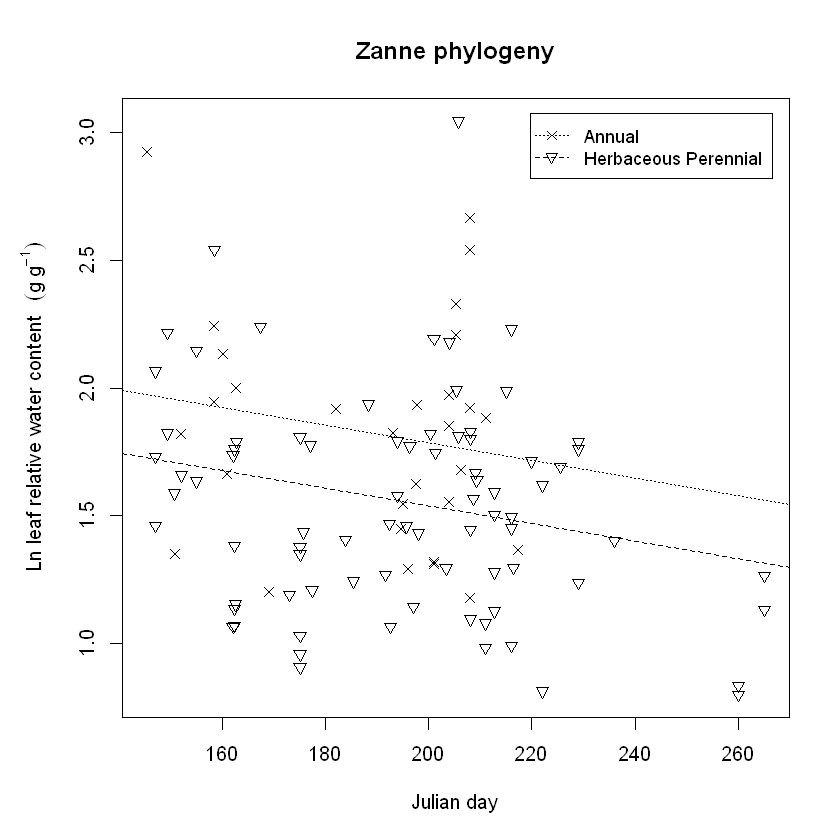

In [27]:
# The Zanne phylogeny has a much better AIC score, so it will be used.

# Reduced model for plotting significant relationships. Lambda from full model.
pglsZ.RWC.Day.herb = pgls(log(RWC) ~ A_HP_WP + Day, z.data.herb, lambda = 1e-06)

op=par(mar = mar.default + c(0, 1, 0, 0))
plot(log(RWC) ~ Day, type='n', data.herb, ylab=expression("Ln leaf relative water content  " ~ (g ~ g^{-1})), 
     xlab="Julian day", main="Zanne phylogeny"
     #, ylim=c(0, 3.5)
    )
points(log(RWC) ~ Day, data=data.herb[data.herb$A_HP_WP == "A", ], pch=4)
points(log(RWC) ~ Day, data=data.herb[data.herb$A_HP_WP == "HP", ], pch=6)
summary(pglsZ.RWC.Day.herb)
# Annual
abline(pglsZ.RWC.Day.herb$model$coef[1], pglsZ.RWC.Day.herb$model$coef[3], lty=3)
# Herbaceous perennial
abline(pglsZ.RWC.Day.herb$model$coef[1] + pglsZ.RWC.Day.herb$model$coef[2], pglsZ.RWC.Day.herb$model$coef[3], lty=2)

legend("topright",
       inset = 0.025,
       cex=0.9,
       c("Annual", "Herbaceous Perennial"),
       lty = c(3,2),
       pch = c(4,6))
par(op)

##### SLA and endopolyploidy for Angiosperms with endopolyploid (EI >= 0.1) leaves

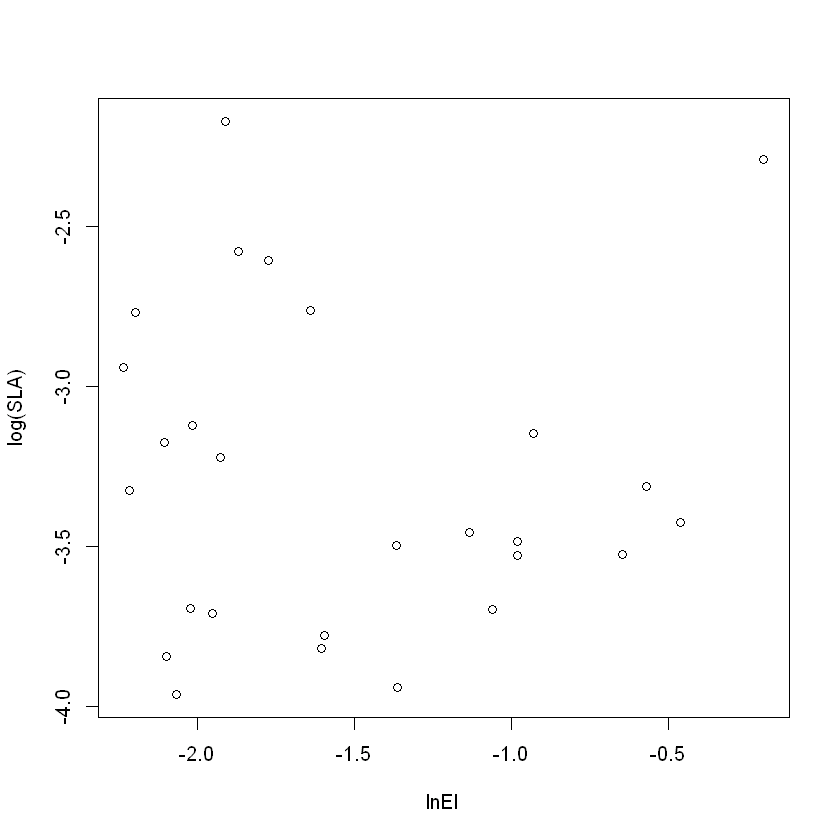

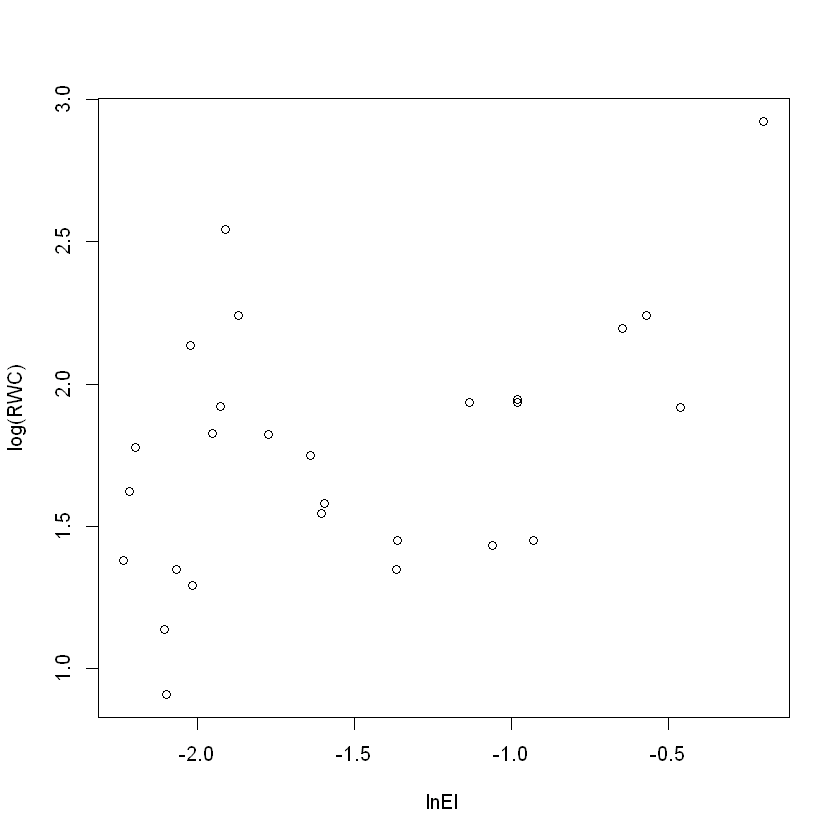

In [28]:
plot(log(SLA) ~ lnEI, data.endo)
plot(log(RWC) ~ lnEI, data.endo)

Significant relationships with SLA

In [29]:
pglsAPG.SLA.EI.endo = pgls(log(SLA) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, apg.data.endo, lambda = 'ML')
summary(pglsAPG.SLA.EI.endo) # EI n.s.
AIC(pglsAPG.SLA.EI.endo) # 27.6
# Zanne phylogeny also gives a lambda of zero; therefore, the APG model is better.


Call:
pgls(formula = log(SLA) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = apg.data.endo, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.043341 -0.016173 -0.006103  0.009291  0.026031 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.000
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = 2.0237e-09
   95.0% CI   : (NA, 0.389)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)       0.7034249  0.8725974  0.8061 0.4301440    
lnEI              0.2135714  0.1449685  1.4732 0.1570643    
A_HP_WPHP        -0.0413949  0.1679182 -0.2465 0.8079248    
CC               -0.0587585  0.0147113 -3.9941 0.0007766 ***
log(Genome.size) -0.0659542  0.0858438 -0.7683 0.4517506    
Day              -0.0096558  0.0040083 -2.4089 0.0263110 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02202 on 19 degrees of freed

[1] 27.59125


Call:
pgls(formula = log(SLA) ~ CC, data = apg.data.herb, lambda = 0.278)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.055097 -0.017436 -0.003051  0.013268  0.059459 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.278
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) -2.0619658  0.2017297 -10.2214 < 2.2e-16 ***
CC          -0.0385708  0.0053716  -7.1805  9.99e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02302 on 106 degrees of freedom
Multiple R-squared: 0.3272,	Adjusted R-squared: 0.3209 
F-statistic: 51.56 on 1 and 106 DF,  p-value: 9.99e-11 


Call:
pgls(formula = log(SLA) ~ Day, data = apg.data.herb, lambda = 0.278)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.083307 -0.019699 -0.001418  0.020280  0.065613 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.278
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -2.4760410  0.3660247 -6.7647 7.576e-10 ***
Day         -0.0046778  0.0018543 -2.5227   0.01313 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02725 on 106 degrees of freedom
Multiple R-squared: 0.05664,	Adjusted R-squared: 0.04774 
F-statistic: 6.364 on 1 and 106 DF,  p-value: 0.01313 

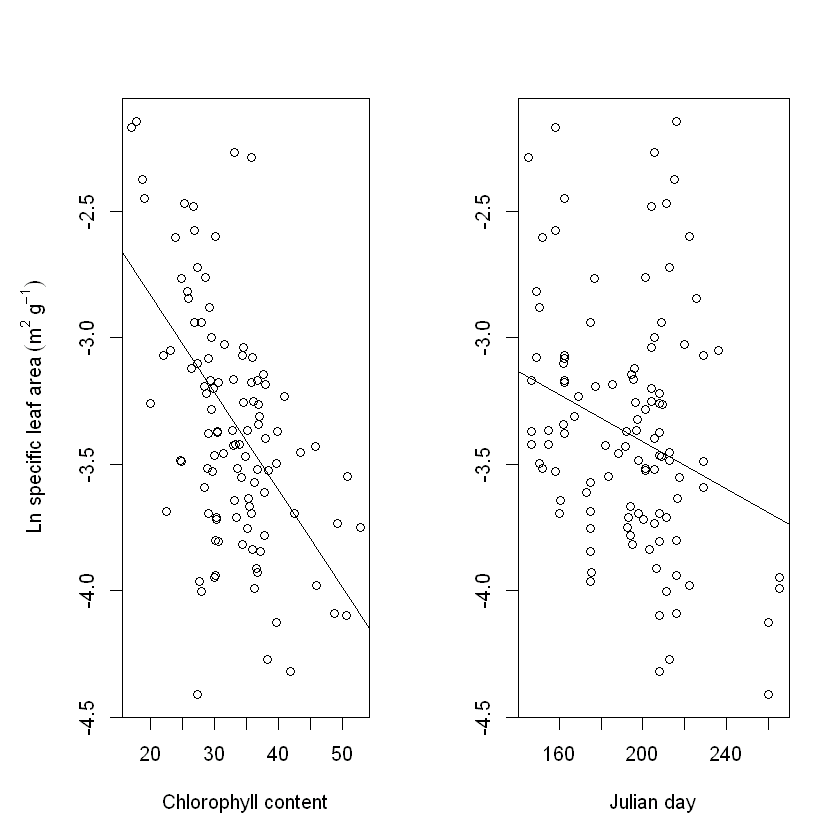

In [30]:
# Reduced models for plotting significant relationships. Use lambda from full model.
pglsAPG.SLA.CC.endo = pgls(log(SLA) ~ CC, apg.data.endo, lambda = 1e-06)
pglsAPG.SLA.Day.endo = pgls(log(SLA) ~ Day, apg.data.endo, lambda = 1e-06)

op=par(mar = mar.default + c(0, 1, 0, 0), mfrow=c(1,2))
plot(log(SLA) ~ CC, data.herb, 
     ylab=expression("Ln specific leaf area" ~ (m^{2} ~ g^{-1})), 
     xlab="Chlorophyll content")
summary(pglsAPG.SLA.CC.herb)
abline(pglsAPG.SLA.CC.herb$model$coef[1], pglsAPG.SLA.CC.herb$model$coef[2])

par(mar=mar.default)
plot(log(SLA) ~ Day, data.herb, ylab="", xlab="Julian day")
summary(pglsAPG.SLA.Day.herb)
abline(pglsAPG.SLA.Day.herb$model$coef[1], pglsAPG.SLA.Day.herb$model$coef[2])

par(op)

Significant relationships with RWC

In [31]:
pglsAPG.RWC.EI.endo = pgls(log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + Day, apg.data.endo, lambda = 'ML')
summary(pglsAPG.RWC.EI.endo)
AIC(pglsAPG.RWC.EI.endo) # 28.9
# Zanne phylogeny also gives a lambda of zero; therefore, the APG model is better.


Call:
pgls(formula = log(RWC) ~ lnEI + A_HP_WP + CC + log(Genome.size) + 
    Day, data = apg.data.endo, lambda = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.030765 -0.012364  0.000744  0.016070  0.047323 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.000
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = 5.0764e-09
   95.0% CI   : (NA, 0.363)
delta  [Fix]  : 1.000

Coefficients:
                   Estimate Std. Error t value  Pr(>|t|)    
(Intercept)       4.4958954  0.8963288  5.0159 7.673e-05 ***
lnEI              0.4621048  0.1489111  3.1032  0.005853 ** 
A_HP_WPHP        -0.1226210  0.1724849 -0.7109  0.485777    
CC               -0.0271194  0.0151114 -1.7946  0.088639 .  
log(Genome.size)  0.0185935  0.0881784  0.2109  0.835240    
Day              -0.0062671  0.0041173 -1.5221  0.144446    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02262 on 19 degrees of freed

[1] 28.9329


Call:
pgls(formula = log(RWC) ~ lnEI, data = apg.data.endo, lambda = 1e-06)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.034893 -0.016232 -0.002747  0.014123  0.063884 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.000
delta  [Fix]  : 1.000

Coefficients:
            Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  2.29756    0.22804  10.075 6.633e-10 ***
lnEI         0.35529    0.14077   2.524   0.01896 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02416 on 23 degrees of freedom
Multiple R-squared: 0.2169,	Adjusted R-squared: 0.1829 
F-statistic:  6.37 on 1 and 23 DF,  p-value: 0.01896 


Call:
pgls(formula = log(RWC) ~ CC, data = apg.data.endo, lambda = 1e-06)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.051041 -0.015536 -0.000842  0.019313  0.040731 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [Fix]  : 0.000
delta  [Fix]  : 1.000

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.000453   0.520932  3.8401 0.000836 ***
CC          -0.007516   0.016132 -0.4659 0.645660    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02718 on 23 degrees of freedom
Multiple R-squared: 0.00935,	Adjusted R-squared: -0.03372 
F-statistic: 0.2171 on 1 and 23 DF,  p-value: 0.6457 

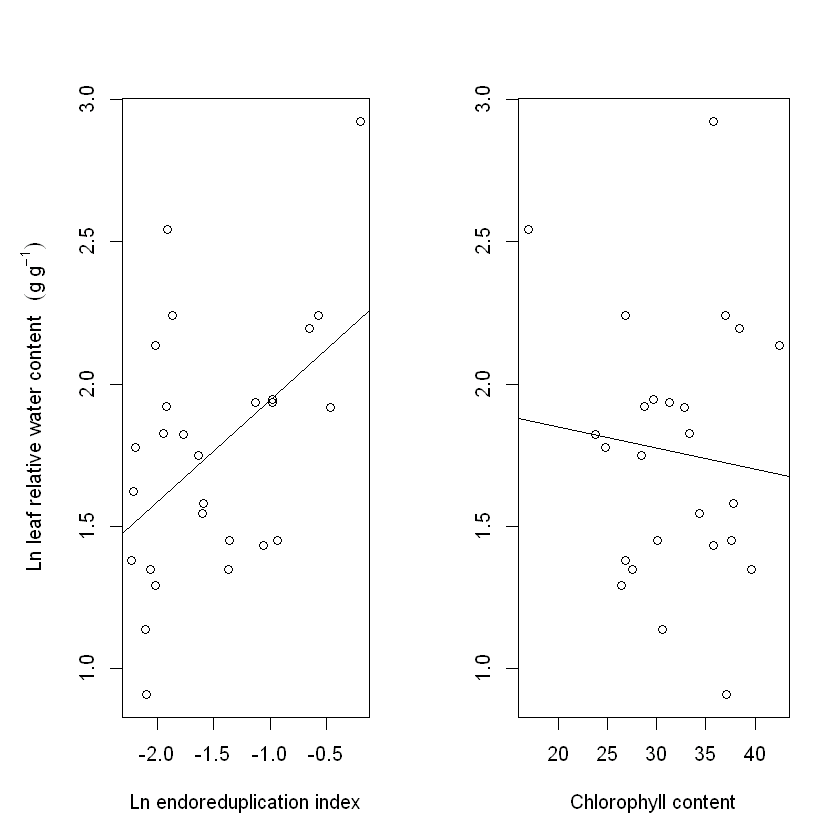

In [32]:
# Reduced models for plotting significant relationships. Use lambda from full model.
pglsAPG.RWC.EI.endo = pgls(log(RWC) ~ lnEI, apg.data.endo, lambda = 1e-06)
pglsAPG.RWC.CC.endo = pgls(log(RWC) ~ CC, apg.data.endo, lambda = 1e-06)

op=par(mar = mar.default + c(0, 1, 0, 0), mfrow=c(1,2))
plot(log(RWC) ~ lnEI, data.endo, 
     ylab=expression("Ln leaf relative water content  " ~ (g ~ g^{-1})), 
     xlab="Ln endoreduplication index")
summary(pglsAPG.RWC.EI.endo)
abline(pglsAPG.RWC.EI.endo$model$coef[1], pglsAPG.RWC.EI.endo$model$coef[2])

par(mar=mar.default)
plot(log(RWC) ~ CC, data.endo, ylab="", xlab="Chlorophyll content")
summary(pglsAPG.RWC.CC.endo)
abline(pglsAPG.RWC.CC.endo$model$coef[1], pglsAPG.RWC.CC.endo$model$coef[2])

par(op)

### Is SLA related to RWC at different levels? Is this a valid test due to the shared mass?

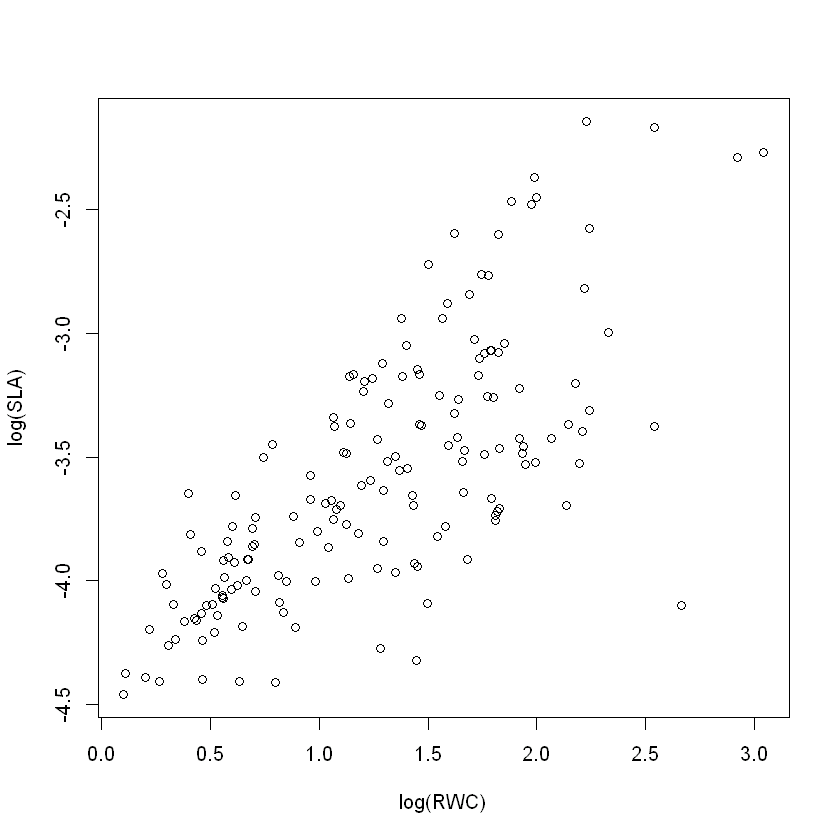

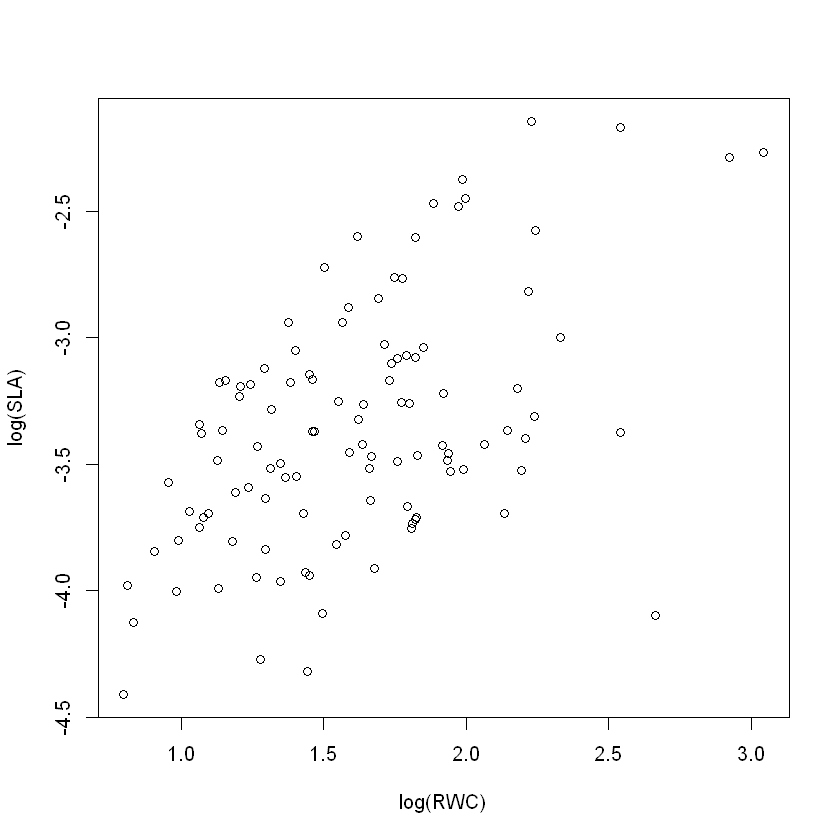

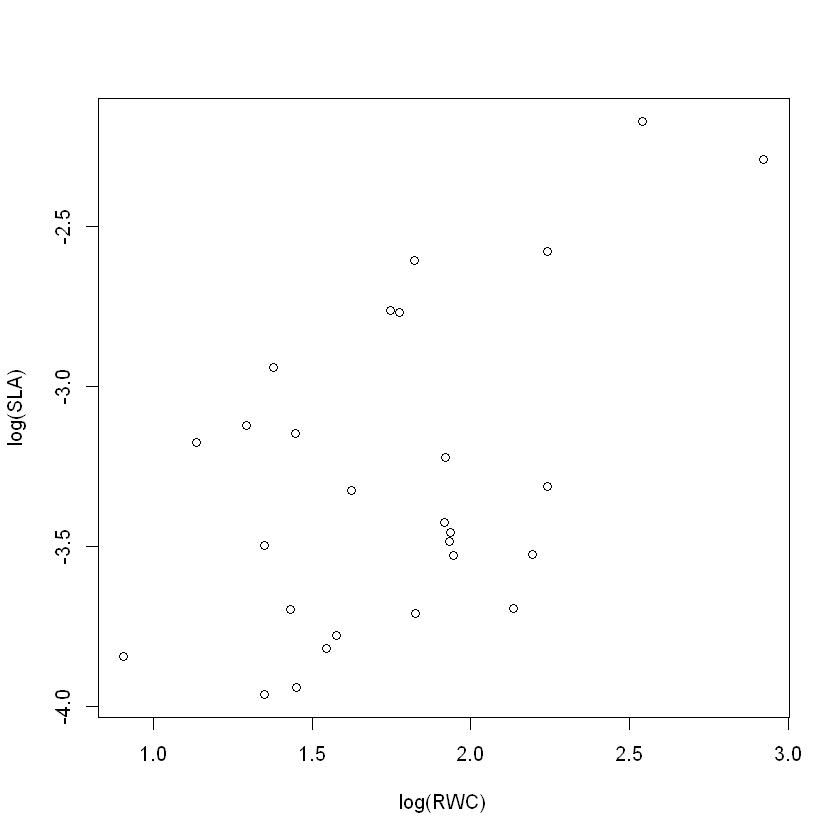

In [33]:
plot(log(SLA) ~ log(RWC), data)
plot(log(SLA) ~ log(RWC), data.herb)
plot(log(SLA) ~ log(RWC), data.endo)